# Detekcja anomalii w tekście z wykorzystaniem metod uczenia maszynowego

Poniższy projekt przedstawia trzy różne podejścia do wykrywania anomalii w tekście, a w szczególności wiadomości spam (Model nr 1 oraz 2) oraz fałszywych wiadomości generowanych automatycznie (Model nr 3), z wykorzystaniem rekurencyjnych sieci neuronowych (LSTM, GRU). Do przetwarzania języka naturalnego (NLP) wykorzystana została metoda "word embedding".   

Użyte biblioteki do ML:  
*   Keras
*   TensorFlow-GPU





Na wejściu do modelu podajemy wektory o wymiarze równym najdłuższej przetworzonej sekwencji. W przypadku gdy sekwencja jest zbyt krótka, poszczególne wektory dopełniamy zerami tak, aby ich wymiary były równe.

## Zestawienie połączenia z Google Drive

W celu zapewnienia poprawnego działania wszystkich poniższych skryptów, wewnątrz swojego dysku google należy utworzyć folder 'ML' oraz umieścić w nim wszystkie niezbędne pliki. Można je pobrać za pomocą poniższego linku:
https://drive.google.com/drive/folders/1FvsaznTq-J2EdRJBiAMsgO8i07JKbmA6?usp=sharing.
Po uruchomienu skryptu konieczne jest przejście przez krótki etap autoryzacji.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Import potrzebnych bibliotek

In [ ]:
import csv
import random
import keras.models
import string
from matplotlib import pyplot as plt
import numpy as np
from keras import Input
from keras import layers
from keras import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, CuDNNLSTM, Dropout, Bidirectional, SimpleRNN, BatchNormalization, GRU, Dropout
from keras.optimizer_v2 import adam
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.utils import shuffle

## Model nr 1- LSTM


Tworzymy listy, w których przechowujemy:  
all_X - wszystkie SMSy (jedna pozycja w liście to jest cały SMS)  
all_y - wszystkie etykiety SMSów (0 - normalny, 1 - spam)  
allSentences - wszystkie smsy (jedna pozycja w liście, to lista słów konkretnego SMSa)  
allSentences potrzebujemy, aby określić jaka jest długość najdłuższego SMSa'

Następnie, wczytujemy plik Spam.CSV.csv i wypełniamy listy.



In [ ]:
all_X = []
all_y = []
allSentences = []

with open('/content/gdrive/MyDrive/ML/SpamCSV.csv', 'r', newline='', encoding='utf8') as csvfile:
    smsReader = csv.DictReader(csvfile)
    for row in smsReader:
        sentence = str(row['sms']).split(sep=" ")
        all_X.append(row['sms'])
        all_y.append(row['sentiment'])
        allSentences.append(sentence)

Następnie, dokonujemy zamiany listy pythonowej określającą etykiety na listę numpy, aby dało się ją wykorzystać w sieci neuronowej.

In [ ]:
for i in range(0, len(all_y)):
    all_y[i] = np.array(int(all_y[i]))
all_y = np.array(all_y)

W kolejnym kroku następuje podział zbioru danych na:


*   Zbiór treningowy (X_train, y_train) - 60% zbioru danych
*   Zbiór walidacyjny (X_val, y_val) - 20% zbioru danych
*   Zbiór testowy (X_test, y_test) - 20% zbioru danych



In [ ]:
X_train, X_rem, y_train, y_rem = train_test_split(all_X, all_y, train_size=0.6)
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, train_size=0.5)

W kolejnym kroku, przygotowujemy dane do embeddingu.

In [ ]:
# Tworzymy tokenizer.
tokenizer = Tokenizer()
# Aktualizuje wewnętrzne słownictwo na podstawie listy tekstów. W przypadku, gdy teksty zawierają listy, przyjmujemy, że każdy wpis na liście jest tokenem.
tokenizer.fit_on_texts(all_X)
# Obliczamy rozmiar słownictwa (możę być większe niż w rzeczywistości, żeby zmniejszyć prawdopodobieństwo kolizji z funkcją hashującą).
vocab_size = len(tokenizer.word_index) + 1

# Transformujemy teksty na ciąg liczb całkowitych
# Uwzględniane są tylko słowa o największej liczbie słów-1 najczęściej występujących. Pod uwagę brane są tylko słowa znane przez tokenizator.
encoded_sms_train = tokenizer.texts_to_sequences(X_train)
encoded_sms_test = tokenizer.texts_to_sequences(X_test)
encoded_sms_val = tokenizer.texts_to_sequences(X_val)

# Obliczamy jaka jest największa długość pojedyńczego SMSa
max_length = len(max(allSentences, key=lambda coll: len(coll)))

# Przekształcamy sekwencję, aby miały tę samą długość.
# Funkcja pad_sequences przekształca listę (o długości num_samples) sekwencji (listy liczb całkowitych) w tablicę
# numpy 2D o kształcie (num_samples, num_timesteps). num_timesteps = maxlen.
# Potrzebujemy sekwencji o tej samej długości w postaci listy Numpy, żeby można było to wrzucić do sieci neuronowej.
padded_sms_train = pad_sequences(encoded_sms_train, maxlen=max_length, padding='post')
padded_sms_test = pad_sequences(encoded_sms_test, maxlen=max_length, padding='post')
padded_sms_val = pad_sequences(encoded_sms_val, maxlen=max_length, padding='post')

Następna funkcja służy do utworzenia warstwy Embeddingu korzystając z gotowego zanurzenia (glove.840B.300d.txt). Tworzenie macierzy embeddingu trwa stosunkowo długo, dlatego została utworzona poniższa funkcja. Wystarczy jednorazowo utworzyć warstwę, a następnie można z niej cały czas korzystać, gdy potrzebne jest dostosowanie hiperparametrów sieci RNN. Warstwa zostaje zapisana do pliku EmbeddingLayerM1.h5 i jest modelem sieci neuronowej typu Embedding posiadający tylko jedną warstwę.

In [ ]:
def createEmbedding(vocab_size, tokenizer, max_length):

    embedding_index = dict()

    # https://github.com/stanfordnlp/GloVe
    f = open('/content/gdrive/MyDrive/ML/glove.840B.300d.txt', encoding='utf8')
    for line in f:
        values = line.split()
        word = values[0]

        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except ValueError:
            for pos in range(len(values[1:])):
                # Jeśli dane słowo nie zostało zdefiniowane w embeddingu, to wpisujemy do wektora liczbę losową z zakresu (-1, 1)
                if pos == '.' or pos == 'name@domain.com':
                    values[pos + 1] = random.randint(-1, 1)
                    coefs = np.asarray(values[1:], dtype='float32')

        embedding_index[word] = coefs
    f.close()

    print('Loaded %s word vectors.' % len(embedding_index))

    # Tworzymy macierz wag embeddingu.
    embedding_matrix = np.zeros((vocab_size, 300))

    for word, i in tokenizer.word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    model = Sequential()
    model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))

    model.save("/content/gdrive/MyDrive/ML/EmbeddingLayerM1.h5")

Poniższą funkcję wystarczy wywołać tylko raz, aby utworzyć plik EmbeddingLayerM1.h5 (warstwę Embeddingu).

In [ ]:
createEmbedding(vocab_size=vocab_size, tokenizer=tokenizer, max_length=max_length)

W poniższym fragmencie następuje trenowanie sieci neuronowej. Na wejściu sieci wykorzystujemy utworzoną wcześniej warstwę Embeddingu, aby dane wejściowe były odpowiednio przetworzone. Warstwa ta nie podlega doszkalaniu (parametr trainable=False). Następnie, wykorzystywana jest warstwa LSTM przystosowana do szkolenia na GPU (wersja CuDNNLSTM). Warstwa Dropout została dodana, aby zmniejszyć ryzyko przeuczenia się modelu.

In [ ]:
embeddingLayer = keras.models.load_model("/content/gdrive/MyDrive/ML/EmbeddingLayerM1.h5")

model = Sequential()
model.add(embeddingLayer)
model.add(Bidirectional(CuDNNLSTM(512, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(padded_sms_train, y_train, epochs=5, validation_data=(padded_sms_val, y_val))

model.save('/content/gdrive/MyDrive/ML/Model1.h5')

model.evaluate(padded_sms_test, y_test)


## Model nr 2- GRU


W pierwszej kolejności wprowadzamy funkcje, które będą przydatne w dalszej części modelu. Są to kolejno:  
*vectorizeSequences*- przetwarzamy sekwencje wejściowe w taki sposób, aby zwrócić wektory reprezentujące zawartości poszczególnych sekwencji  
*accPlot*- służy do wyśwetlania wykresu dokładności  
*lossPlot*- służy do wyświetlania wykresu strat  
*remove_punctation*- usuwanie nieistotnych w naszym przypadku znaków interpunkcyjnych

In [ ]:
def vectorizeSequences(sequences, dimension):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1

    return results


def accPlot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'ro', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Accuracy of training and validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


def lossPlot(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Loss of training and validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


def remove_punctuation(text):
    punctuation_free = "".join([i for i in text if i not in string.punctuation])
    return punctuation_free

W kolejnym kroku należy odpowiednio przygotować dane, w taki sposób, aby nadawały się do dalszego przetwarzania. Wczytujemy dane z dysku, a następnie przypisujemy je do zmiennych:  
x - wszystkie SMSy (jedna pozycja w liście to jest cały SMS)  
y - wszystkie etykiety SMSów (0 - normalny, 1 - spam)  
Konieczne jest również wydzielenie podzbioru treningowego, spośród całego zbioru danych  
Należy także obrobić dane- usuwamy znaki interpunkcyjne oraz zmieniamy wielkość znaków.

In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/ML/SpamCSV.csv", encoding="ISO-8859-1")
pd.set_option('display.max_colwidth', None)
data = data[['sms', 'sentiment']]

y = data.drop(columns=['sms']).copy()
X = data['sms']

print(X)
print(y)
y_train, y_rem, X_train, X_rem = train_test_split(y, X, train_size=0.7)

X_train = X_train.apply(lambda x: remove_punctuation(x))
X_train = X_train.apply(lambda x: x.lower())

max_length = len(max(X_train, key=lambda coll: len(coll)))

# Tworzymy tokenizer.
tokenizer = Tokenizer()
# Aktualizuje wewnętrzne słownictwo na podstawie listy tekstów. W przypadku, gdy teksty zawierają listy, przyjmujemy, że każdy wpis na liście jest tokenem.
tokenizer.fit_on_texts(X_train)
# Obliczamy rozmiar słownictwa (możę być większe niż w rzeczywistości, żeby zmniejszyć prawdopodobieństwo kolizji z funkcją hashującą).
vocab_size = len(tokenizer.word_index) + 1

# Transformujemy teksty na ciąg liczb całkowitych
# Uwzględniane są tylko słowa o największej liczbie słów-1 najczęściej występujących. Pod uwagę brane są tylko słowa znane przez tokenizator.
X_train = tokenizer.texts_to_sequences(X_train)

# Przekształcamy sekwencję, aby miały tę samą długość.
# Funkcja pad_sequences przekształca listę (o długości num_samples) sekwencji (listy liczb całkowitych) w tablicę
# numpy 2D o kształcie (num_samples, num_timesteps). num_timesteps = maxlen.
# Potrzebujemy sekwencji o tej samej długości w postaci listy Numpy, żeby można było to wrzucić do sieci neuronowej.
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')

Następna funkcja służy do utworzenia warstwy Embeddingu korzystając z gotowego zanurzenia (glove.840B.300d.txt). Tworzenie macierzy embeddingu trwa stosunkowo długo, dlatego została utworzona poniższa funkcja. Wystarczy jednorazowo utworzyć warstwę, a następnie można z niej cały czas korzystać, gdy potrzebne jest dostosowanie hiperparametrów sieci RNN. Warstwa zostaje zapisana do pliku EmbeddingLayerM2.h5 i jest modelem sieci neuronowej typu Embedding posiadający tylko jedną warstwę.

In [ ]:
def createEmbedding(vocab_size, tokenizer, max_length):

    embedding_index = dict()

    f = open('/content/gdrive/MyDrive/ML/glove.840B.300d.txt', encoding='utf8')
    for line in f:
        values = line.split()
        word = values[0]

        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except ValueError:
            for pos in range(len(values[1:])):
                # Jeśli dane słowo nie zostało zdefiniowane w embeddingu, to wpisujemy do wektora liczbę losową z zakresu (-1, 1)
                if pos == '.' or pos == 'name@domain.com':
                    values[pos + 1] = random.randint(-1, 1)
                    coefs = np.asarray(values[1:], dtype='float32')

        embedding_index[word] = coefs
    f.close()

    print('Loaded %s word vectors.' % len(embedding_index))

    # Tworzymy macierz wag embeddingu.
    embedding_matrix = np.zeros((vocab_size, 300))

    for word, i in tokenizer.word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    model = Sequential()
    model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=True))

    model.save("/content/gdrive/MyDrive/ML/EmbeddingLayerM2.h5")

Poniższą funkcję wystarczy wywołać tylko raz, aby utworzyć plik EmbeddingLayerM2.h5 (warstwę Embeddingu).

In [ ]:
createEmbedding(vocab_size=vocab_size, tokenizer=tokenizer, max_length=max_length)

W poniższym fragmencie następuje trenowanie sieci neuronowej. Na wejściu sieci wykorzystujemy utworzoną wcześniej warstwę Embeddingu, aby dane wejściowe były odpowiednio przetworzone. Następnie, wykorzystywana jest warstwa GRU. Warstwa Dropout została dodana, aby zmniejszyć ryzyko przeuczenia się modelu.  
Tworzymy także wykresy, aby zobrazować otrzymane wyniki

Epoch 1/5
98/98 [==============================] - 14s 115ms/step - loss: 0.4533 - accuracy: 0.8738 - val_loss: 0.4469 - val_accuracy: 0.8729
Epoch 2/5
98/98 [==============================] - 11s 111ms/step - loss: 0.2847 - accuracy: 0.9128 - val_loss: 0.0994 - val_accuracy: 0.9700
Epoch 3/5
98/98 [==============================] - 11s 112ms/step - loss: 0.0594 - accuracy: 0.9854 - val_loss: 0.0949 - val_accuracy: 0.9713
Epoch 4/5
98/98 [==============================] - 11s 111ms/step - loss: 0.0384 - accuracy: 0.9898 - val_loss: 0.0797 - val_accuracy: 0.9765
Epoch 5/5
98/98 [==============================] - 12s 119ms/step - loss: 0.0257 - accuracy: 0.9939 - val_loss: 0.0813 - val_accuracy: 0.9801
6883


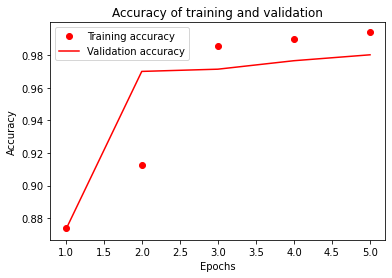

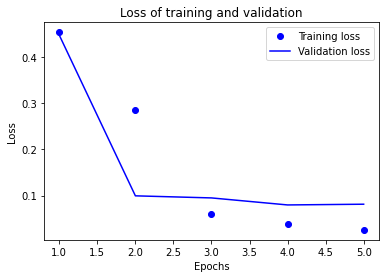

In [ ]:
embeddingLayer = keras.models.load_model("/content/gdrive/MyDrive/ML/EmbeddingLayerM2.h5")

model = Sequential()
model.add(embeddingLayer)
model.add(GRU(512, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x=X_train, y=y_train, validation_split=0.2, batch_size=32, shuffle=True, epochs=5)

print(vocab_size)
accPlot(history)
lossPlot(history)

X_rem = X_rem.apply(lambda x: remove_punctuation(x))
X_rem = X_rem.apply(lambda x: x.lower())

max_length = len(max(X_rem, key=lambda coll: len(coll)))

# tokenizer = Tokenizer()
# vocab_size = len(tokenizer.word_index) + 1
X_rem = tokenizer.texts_to_sequences(X_rem)
X_rem = pad_sequences(X_rem, maxlen=max_length, padding='post')
# response = model.evaluate(x=X_rem, y=y_rem)

model.save('/content/gdrive/MyDrive/ML/Model2.h5')


## Model nr 3

W piwerwszej kolejności wczytujemy dane z dysku:  
*false_data*- wiadomości wygenerowane przez boty  
*true_data*- wiadomości prawdziwe


In [ ]:
false_data = pd.read_csv('/content/gdrive/MyDrive/ML/Fake.csv', encoding="ISO-8859-1")
false_data["Label"] = 0
true_data = pd.read_csv('/content/gdrive/MyDrive/ML/True.csv', encoding="ISO-8859-1")
true_data["Label"] = 1

Konkatenacja dwóch csvek do jednej

In [ ]:
final_data = pd.concat([true_data, false_data], ignore_index=True)
final_data = shuffle(final_data)

pd.set_option('display.max_colwidth', None)
final_data = final_data[['title','Label']]

x = final_data['title']
y = final_data['Label']
# y_train, y_rem, X_train, X_rem = train_test_split(y, x, train_size=0.75)

final_data.to_csv('final.csv',index=False)

Embedding

In [ ]:

f = open('/content/gdrive/MyDrive/ML/glove.6B.300d.txt', encoding='utf-8')

embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embedding_index))

Found 400000 word vectors.


Następnie wprowadzamy funkcje, które będą przydatne w dalszej części modelu. Są to kolejno:  
*vectorizeSequences*- przetwarzamy sekwencje wejściowe w taki sposób, aby zwrócić wektory reprezentujące zawartości poszczególnych sekwencji  
*accPlot*- służy do wyśwetlania wykresu dokładności  
*lossPlot*- służy do wyświetlania wykresu strat  
*remove_punctation*- usuwanie nieistotnych w naszym przypadku znaków interpunkcyjnych

In [ ]:
def vectorizeSequences(sequences, dimension):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1

    return results


def accPlot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'ro', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Accuracy of training and validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


def lossPlot(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Loss of training and validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


def remove_punctuation(text):
    punctuation_free = "".join([i for i in text if i not in string.punctuation])
    return punctuation_free

Przygotowywujemy danę tak jak w poprzednich przypadkach, tym razem jednak nie używamy funkcji .lower(), gdyż po obejrzeniu danych zauważyliśmy, że w fałszywych newsach często używa się caps lock'a.

Następnie przygotowywujemy dane do uczenia w następujący sposób:



1.   Przygotowanie danych -> usunięcie znaków interpunkcyjnych (w pozostałych modelach w tym kroku, także sprowadzenie tekstu do małych liter)
2.   Wektoryzacja tekstu (Ala ma kota -> [5 13 8])
3.   Wypełnienie wektora zerami, aby długość utworzonych wektorów była taka sama ([5 13 8] -> [5 13 8 0 0 0 0 ])



In [ ]:
# ----------- TITLE -------------
title = final_data['title']
# title = X_train
title = title.apply(lambda x: remove_punctuation(x))
# title = title.apply(lambda x: x.lower())

max_length_title = len(max(title, key=lambda coll: len(coll)))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(title)
vocab_size_title = len(tokenizer.word_index) + 1

title = tokenizer.texts_to_sequences(title)
title = pad_sequences(title, maxlen=max_length_title, padding='post')

Tworzymy macierz Embeddingu

In [ ]:
# -------TITLE EMBEDDING MATRIX --------
title_embedding_matrix = np.zeros((vocab_size_title, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        title_embedding_matrix[i] = embedding_vector

W podanym niżej modelu możemy analizować kontekst między słowami występującymi w tytule, gdyż na wejściu podajemy stokenizowaną sekwencję tekstu. Sekwenca ta trafia na:

1.   Warstwę embeddingu

2.   Warstwę rekurencyjna GRU
3.   Warstwę głęboka
4.   Kolejną warstwę rekurencyjna GRU
5.   Warstwę głęboka 



Epoch 1/4
281/281 [==============================] - 380s 1s/step - loss: 0.4105 - accuracy: 0.8220 - val_loss: 0.2578 - val_accuracy: 0.9266
Epoch 2/4
281/281 [==============================] - 369s 1s/step - loss: 0.1817 - accuracy: 0.9403 - val_loss: 0.1338 - val_accuracy: 0.9542
Epoch 3/4
281/281 [==============================] - 371s 1s/step - loss: 0.1149 - accuracy: 0.9628 - val_loss: 0.1016 - val_accuracy: 0.9629
Epoch 4/4
281/281 [==============================] - 369s 1s/step - loss: 0.0715 - accuracy: 0.9741 - val_loss: 0.0831 - val_accuracy: 0.9692


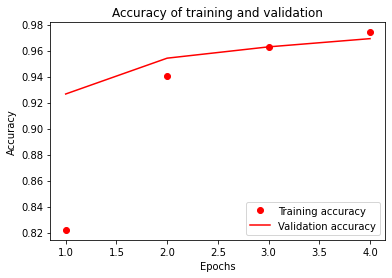

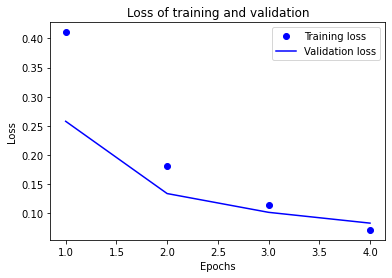

In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size_title, 300, weights=[title_embedding_matrix],
                    input_length=max_length_title))
model.add(layers.GRU(512,return_sequences=True,activation='relu'))
model.add(layers.Dense(12, activation='sigmoid'))
model.add(layers.GRU(265,return_sequences=True,activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
# opt = adam.Adam(learning_rate=0.000001)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(title,y, validation_split=0.2, batch_size=128, shuffle=True, epochs=4, verbose=1)

model.save('/content/gdrive/MyDrive/ML/Model3.h5')

accPlot(history)
lossPlot(history)
